In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Neural_Network (nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential (
            nn.Linear (input_dim, hidden_dim),
            
            nn.Tanh (),

            nn.Linear (hidden_dim, hidden_dim), 

            nn.Tanh (),

            nn.Linear (hidden_dim, hidden_dim),
            nn.Tanh (),
            nn.Linear (hidden_dim, hidden_dim),
            nn.Tanh (),
            nn.Linear (hidden_dim, output_dim),

            nn.Tanh ()
        )

    def forward (self, time):
        return self.model (time)
    
model = Neural_Network(1, 32, 1)

In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)  
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  

In [4]:
model.parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [5]:
#option parametrs
g = 9.81
L = 5
theta_max = torch.pi / 32
h = L * (1-torch.cos (torch.tensor(theta_max)))
V = torch.sqrt (torch.tensor (2*g*h))
#для распараллеливания процесса вычисления, подавать будем сразу вектор со всеми значениями
t = torch.linspace (0, 5, 100,requires_grad=True).reshape (-1,1)

C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4216716452.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V = torch.sqrt (torch.tensor (2*g*h))


In [6]:
def compute_loss(predict, equation_weight=1.0, initial_weight=1.0,
                 bound_T = 0, bound_3T4 = 0, bound_T2 = 0, bound_T4 = 0,
                enable_velocity_conditions=False):
    
    
    dangle_dt = torch.autograd.grad(predict, t, grad_outputs=torch.ones_like(predict), create_graph=True)[0]
    dangle_dt_2 = torch.autograd.grad(dangle_dt, t, grad_outputs=torch.ones_like(predict), create_graph=True)[0]
    equation_loss = torch.mean((dangle_dt_2 + (g/L)*torch.sin(predict))**2 * equation_weight)
    
    
    initial_cond_loss = 0.0
    if initial_weight > 0:
        t0 = torch.zeros(1,1).requires_grad_(True)
        predict_initial = model(t0)
        dtheta_dt0_pred = torch.autograd.grad(predict_initial, t0, grad_outputs=torch.ones_like(predict_initial), create_graph=True)[0]
        initial_cond_loss = (
            torch.mean((predict_initial - theta_max)**2) + 
            torch.mean(dtheta_dt0_pred**2)
        ) * initial_weight
    
    T_approx =  2 * torch.pi * torch.sqrt (torch.tensor (L/g))
    
    period_loss = 0.0
    near_period_loss = 0.0
    half_period_loss = 0.0
    almost_period_loss = 0.0

    if bound_T > 0:
        t_T = torch.tensor(T_approx).reshape (-1, 1).requires_grad_(True)
        predict_period = model (t_T)
        period_loss = torch.mean ((predict_period-theta_max)**2) * bound_T
    
    if bound_3T4 > 0:
        t_3T = torch.tensor(3*T_approx/4).reshape (-1, 1).requires_grad_(True)
        predict_near_period = model (t_3T)
        near_period_loss = torch.mean ((predict_near_period-0.0)**2) * bound_3T4

    if bound_T2 > 0:
        t_T2 = torch.tensor(T_approx/2).reshape (-1, 1).requires_grad_(True)
        predict_half_period = model (t_T2)
        half_period_loss = torch.mean ((predict_half_period-(-theta_max))**2) * bound_T2

    if bound_T4 > 0:
        t_T4 = torch.tensor(T_approx/4).reshape (-1, 1).requires_grad_(True)
        predict_almost_period = model (t_T4)
        almost_period_loss = torch.mean ((predict_almost_period-0.0))**2 * bound_T4

    return equation_loss + initial_cond_loss + period_loss + near_period_loss + half_period_loss + almost_period_loss

In [7]:
epochs = 20000

In [8]:
from tqdm import tqdm

model.apply (init_weights)

min_loss = 1
Flag = False
loss_equation = []
model.train ()
with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
    for epoch in range(epochs):
        pred = model(t)
        optimizer.zero_grad()
        loss = compute_loss(pred, 10, 0, 0, 0, 0)
        
        loss_equation.append (loss.detach().numpy())
        loss.backward()
        optimizer.step()
        if loss < min_loss:
            min_loss = loss
            temp_weight = model.state_dict()
            best_loss = loss
            Flag = True
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"}) 
        pbar.update(1)  

print (f'Best loss {best_loss.item()}')
model.load_state_dict (temp_weight)


if Flag:
    print ('Weight become diff')

model.eval()
test_time = torch.linspace (0, 5, 100, requires_grad=True).reshape (-1, 1)
predict_model_equation = model (test_time)

Training: 100%|██████████| 20000/20000 [00:59<00:00, 337.83epoch/s, Loss=0.0000]

Best loss 1.589154723002288e-15
Weight become diff


In [9]:
T_approx = 2 * torch.pi * torch.sqrt (torch.tensor (L/g))

In [10]:
t_zero = torch.tensor (0.0).reshape (-1, 1).requires_grad_(True)
t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T = torch.tensor (T_approx).reshape (-1, 1).requires_grad_(True)

value_zero = model(t_zero)
value_t4 = model(t_T4)
value_t2 = model(t_T2)
value_t34 = model(t_T34)
value_T = model(t_T)


def calculate_percent_deviation(predicted_values, expected_values):
    # Преобразуем значения в тензоры, если они не являются таковыми
    predicted_values = torch.tensor(predicted_values)
    expected_values = torch.tensor(expected_values)
    
    # Вычисляем процентное отклонение
    percent_deviation = torch.abs((predicted_values - expected_values) / expected_values) * 100
    
    return percent_deviation

# Ваши предсказанные значения
predicted_values = [
    value_zero.item(),
    value_t4.item(),
    value_t2.item(),
    value_t34.item(),
    value_T.item()
]

# Ожидаемые значения
expected_values = [
    torch.pi / 32,
    0.0,
    -torch.pi / 32,
    0.0,
    torch.pi / 32
]

# Вычисляем процентное отклонение
percent_deviation = calculate_percent_deviation(predicted_values, expected_values)

# Выводим результат
for i, deviation in enumerate(percent_deviation):
    print(f"Point {i}: Percent Deviation = {deviation.item()}%")

# Вычисляем суммарный процент отклонения
# Обрабатываем случаи, когда ожидаемое значение равно 0
valid_deviations = percent_deviation[expected_values != 0]  # Исключаем нулевые значения
if valid_deviations.numel() > 0:
    average_percent_deviation = valid_deviations.mean()
    print(f"Average Percent Deviation (excluding zero values): {average_percent_deviation.item()}%")
else:
    print("No valid deviations to calculate average.")


Point 0: Percent Deviation = 100.0000228881836%
Point 1: Percent Deviation = inf%
Point 2: Percent Deviation = 100.00001525878906%
Point 3: Percent Deviation = inf%
Point 4: Percent Deviation = 99.99998474121094%
Average Percent Deviation (excluding zero values): inf%


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).require

In [11]:
from tqdm import tqdm

model.apply (init_weights)

min_loss = 1

loss_initial = []
model.train ()

Flag = False


with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
    for epoch in range(epochs):
        pred = model(t)
        optimizer.zero_grad()
        loss = compute_loss(pred, 1, 10, 0, 0, 0)
        
        loss_initial.append (loss.detach().numpy())
        loss.backward()
        optimizer.step()
        if loss < min_loss:
            min_loss = loss
            temp_weight = model.state_dict()
            best_loss = loss
            Flag = True
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"}) 
        pbar.update(1)  

if Flag:
    print ('Weight become diff')

    
print (f'Best loss {best_loss.item()}')

model.load_state_dict (temp_weight)

model.eval()
predict_model_initial = model (test_time)

Training: 100%|██████████| 20000/20000 [01:15<00:00, 263.37epoch/s, Loss=0.0000]

Weight become diff
Best loss 1.273708562621323e-06


In [12]:
t_zero = torch.tensor (0.0).reshape (-1, 1).requires_grad_(True)
t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T = torch.tensor (T_approx).reshape (-1, 1).requires_grad_(True)

value_zero = model(t_zero)
value_t4 = model(t_T4)
value_t2 = model(t_T2)
value_t34 = model(t_T34)
value_T = model(t_T)


def calculate_percent_deviation(predicted_values, expected_values):
    # Преобразуем значения в тензоры, если они не являются таковыми
    predicted_values = torch.tensor(predicted_values)
    expected_values = torch.tensor(expected_values)
    
    # Вычисляем процентное отклонение
    percent_deviation = torch.abs((predicted_values - expected_values) / expected_values) * 100
    
    return percent_deviation

# Ваши предсказанные значения
predicted_values = [
    value_zero.item(),
    value_t4.item(),
    value_t2.item(),
    value_t34.item(),
    value_T.item()
]

# Ожидаемые значения
expected_values = [
    torch.pi / 32,
    0.0,
    -torch.pi / 32,
    0.0,
    torch.pi / 32
]

# Вычисляем процентное отклонение
percent_deviation = calculate_percent_deviation(predicted_values, expected_values)

# Выводим результат
for i, deviation in enumerate(percent_deviation):
    print(f"Point {i}: Percent Deviation = {deviation.item()}%")

# Вычисляем суммарный процент отклонения
# Обрабатываем случаи, когда ожидаемое значение равно 0
valid_deviations = percent_deviation[expected_values != 0]  # Исключаем нулевые значения
if valid_deviations.numel() > 0:
    average_percent_deviation = valid_deviations.mean()
    print(f"Average Percent Deviation (excluding zero values): {average_percent_deviation.item()}%")
else:
    print("No valid deviations to calculate average.")


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)


Point 0: Percent Deviation = 0.16201967000961304%
Point 1: Percent Deviation = inf%
Point 2: Percent Deviation = 0.2500987648963928%
Point 3: Percent Deviation = inf%
Point 4: Percent Deviation = 0.16192100942134857%
Average Percent Deviation (excluding zero values): inf%


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T = torch.tensor (T_approx).reshape (-1, 1).requires_gra

In [13]:
from tqdm import tqdm

model.apply (init_weights)

min_loss = 1

loss_initial_boundary_1 = []
model.train ()
Flag = False
with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
    for epoch in range(epochs):
        pred = model(t)
        optimizer.zero_grad()
        loss = compute_loss(pred, 1, 10, 0.1, 0, 0.1, 0)
        
        loss_initial_boundary_1.append (loss.detach().numpy())
        loss.backward()
        optimizer.step()
        if loss < min_loss:
            min_loss = loss
            temp_weight = model.state_dict()
            best_loss = loss
            Flag = True
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"}) 
        pbar.update(1)  

if Flag:
    print ('Weight become diff')
    
print (best_loss)

model.load_state_dict (temp_weight)

model.eval()
predict_model_boundary_1 = model (test_time)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T = torch.tensor(T_approx).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor(T_approx/2).reshape (-1, 1).requires_grad_(True)
Training: 100%|██████████| 20000/20000 [01:28<00:00, 227.09epoch/s, Loss=0.0001]

Weight become diff
tensor(6.9361e-07, grad_fn=<AddBackward0>)


In [14]:
t_zero = torch.tensor (0.0).reshape (-1, 1).requires_grad_(True)
t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T = torch.tensor (T_approx).reshape (-1, 1).requires_grad_(True)

value_zero = model(t_zero)
value_t4 = model(t_T4)
value_t2 = model(t_T2)
value_t34 = model(t_T34)
value_T = model(t_T)


def calculate_percent_deviation(predicted_values, expected_values):
    # Преобразуем значения в тензоры, если они не являются таковыми
    predicted_values = torch.tensor(predicted_values)
    expected_values = torch.tensor(expected_values)
    
    # Вычисляем процентное отклонение
    percent_deviation = torch.abs((predicted_values - expected_values) / expected_values) * 100
    
    return percent_deviation

# Ваши предсказанные значения
predicted_values = [
    value_zero.item(),
    value_t4.item(),
    value_t2.item(),
    value_t34.item(),
    value_T.item()
]

# Ожидаемые значения
expected_values = [
    torch.pi / 32,
    0.0,
    -torch.pi / 32,
    0.0,
    torch.pi / 32
]

# Вычисляем процентное отклонение
percent_deviation = calculate_percent_deviation(predicted_values, expected_values)

# Выводим результат
for i, deviation in enumerate(percent_deviation):
    print(f"Point {i}: Percent Deviation = {deviation.item()}%")

# Вычисляем суммарный процент отклонения
# Обрабатываем случаи, когда ожидаемое значение равно 0
valid_deviations = percent_deviation[expected_values != 0]  # Исключаем нулевые значения
if valid_deviations.numel() > 0:
    average_percent_deviation = valid_deviations.mean()
    print(f"Average Percent Deviation (excluding zero values): {average_percent_deviation.item()}%")
else:
    print("No valid deviations to calculate average.")


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).require

Point 0: Percent Deviation = 2.4779317378997803%
Point 1: Percent Deviation = inf%
Point 2: Percent Deviation = 2.9423999786376953%
Point 3: Percent Deviation = inf%
Point 4: Percent Deviation = 1.8855952024459839%
Average Percent Deviation (excluding zero values): inf%


In [15]:
from tqdm import tqdm

model.apply (init_weights)

min_loss = 1

loss_initial_boundary_2 = []
model.train ()
Flag = False
with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
    for epoch in range(epochs):
        pred = model(t)
        optimizer.zero_grad()
        loss = compute_loss(pred, 1, 10, 0, 0.1, 0, 0.1)
        
        loss_initial_boundary_2.append (loss.detach().numpy())
        loss.backward()
        optimizer.step()
        if loss < min_loss:
            min_loss = loss
            temp_weight = model.state_dict()
            best_loss = loss
            Flag = True
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"}) 
        pbar.update(1)  

if Flag:
    print ('Weight become diff')
    
print (best_loss)

model.load_state_dict (temp_weight)

model.eval()
predict_model_boundary_2 = model (test_time)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_3T = torch.tensor(3*T_approx/4).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor(T_approx/4).reshape (-1, 1).requires_grad_(True)
Training: 100%|██████████| 20000/20000 [01:28<00:00, 226.77epoch/s, Loss=0.0000]

Weight become diff
tensor(3.5696e-06, grad_fn=<AddBackward0>)


In [16]:
t_zero = torch.tensor (0.0).reshape (-1, 1).requires_grad_(True)
t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T = torch.tensor (T_approx).reshape (-1, 1).requires_grad_(True)

value_zero = model(t_zero)
value_t4 = model(t_T4)
value_t2 = model(t_T2)
value_t34 = model(t_T34)
value_T = model(t_T)


def calculate_percent_deviation(predicted_values, expected_values):
    # Преобразуем значения в тензоры, если они не являются таковыми
    predicted_values = torch.tensor(predicted_values)
    expected_values = torch.tensor(expected_values)
    
    # Вычисляем процентное отклонение
    percent_deviation = torch.abs((predicted_values - expected_values) / expected_values) * 100
    
    return percent_deviation

# Ваши предсказанные значения
predicted_values = [
    value_zero.item(),
    value_t4.item(),
    value_t2.item(),
    value_t34.item(),
    value_T.item()
]

# Ожидаемые значения
expected_values = [
    torch.pi / 32,
    0.0,
    -torch.pi / 32,
    0.0,
    torch.pi / 32
]

# Вычисляем процентное отклонение
percent_deviation = calculate_percent_deviation(predicted_values, expected_values)

# Выводим результат
for i, deviation in enumerate(percent_deviation):
    print(f"Point {i}: Percent Deviation = {deviation.item()}%")

# Вычисляем суммарный процент отклонения
# Обрабатываем случаи, когда ожидаемое значение равно 0
valid_deviations = percent_deviation[expected_values != 0]  # Исключаем нулевые значения
if valid_deviations.numel() > 0:
    average_percent_deviation = valid_deviations.mean()
    print(f"Average Percent Deviation (excluding zero values): {average_percent_deviation.item()}%")
else:
    print("No valid deviations to calculate average.")


Point 0: Percent Deviation = 0.3063795268535614%
Point 1: Percent Deviation = inf%
Point 2: Percent Deviation = 0.9048178791999817%
Point 3: Percent Deviation = inf%
Point 4: Percent Deviation = 0.876594066619873%
Average Percent Deviation (excluding zero values): inf%


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).require

In [17]:
from tqdm import tqdm

model.apply (init_weights)

min_loss = 3

loss_initial_period = []
model.train ()
Flag = False
with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
    for epoch in range(epochs):
        pred = model(t)
        optimizer.zero_grad()
        loss = compute_loss(pred, 1, 10, 0.1, 0.1, 0.1, 0.1)
        
        loss_initial_period.append (loss.detach().numpy())
        loss.backward()
        optimizer.step()
        if loss < min_loss:
            min_loss = loss
            temp_weight = model.state_dict()
            best_loss = loss
            Flag = True
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"}) 
        pbar.update(1)  

if Flag:
    print ('Weight become diff')
    
print (best_loss)

model.load_state_dict (temp_weight)

model.eval()
predict_model_period = model (test_time)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T = torch.tensor(T_approx).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_3T = torch.tensor(3*T_approx/4).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torc

Weight become diff
tensor(7.2532e-06, grad_fn=<AddBackward0>)


In [18]:
t_zero = torch.tensor (0.0).reshape (-1, 1).requires_grad_(True)
t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T = torch.tensor (T_approx).reshape (-1, 1).requires_grad_(True)

value_zero = model(t_zero)
value_t4 = model(t_T4)
value_t2 = model(t_T2)
value_t34 = model(t_T34)
value_T = model(t_T)


def calculate_percent_deviation(predicted_values, expected_values):
    # Преобразуем значения в тензоры, если они не являются таковыми
    predicted_values = torch.tensor(predicted_values)
    expected_values = torch.tensor(expected_values)
    
    # Вычисляем процентное отклонение
    percent_deviation = torch.abs((predicted_values - expected_values) / expected_values) * 100
    
    return percent_deviation

# Ваши предсказанные значения
predicted_values = [
    value_zero.item(),
    value_t4.item(),
    value_t2.item(),
    value_t34.item(),
    value_T.item()
]

# Ожидаемые значения
expected_values = [
    torch.pi / 32,
    0.0,
    -torch.pi / 32,
    0.0,
    torch.pi / 32
]

# Вычисляем процентное отклонение
percent_deviation = calculate_percent_deviation(predicted_values, expected_values)

# Выводим результат
for i, deviation in enumerate(percent_deviation):
    print(f"Point {i}: Percent Deviation = {deviation.item()}%")

# Вычисляем суммарный процент отклонения
# Обрабатываем случаи, когда ожидаемое значение равно 0
valid_deviations = percent_deviation[expected_values != 0]  # Исключаем нулевые значения
if valid_deviations.numel() > 0:
    average_percent_deviation = valid_deviations.mean()
    print(f"Average Percent Deviation (excluding zero values): {average_percent_deviation.item()}%")
else:
    print("No valid deviations to calculate average.")


Point 0: Percent Deviation = 0.02378423511981964%
Point 1: Percent Deviation = inf%
Point 2: Percent Deviation = 0.36171162128448486%
Point 3: Percent Deviation = inf%
Point 4: Percent Deviation = 0.472064733505249%
Average Percent Deviation (excluding zero values): inf%


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).require

In [19]:
from tqdm import tqdm

model.apply (init_weights)

min_loss = 3

loss_initial_dynamic = []
model.train ()
Flag = False
with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
    for epoch in range(epochs):
        
        pred = model(t)
        optimizer.zero_grad()
        
        if epoch <= 5000:
            loss = compute_loss(pred, 1, 10, 0, 0, 0, 0)
        elif 5000<epoch<=10000:
            loss = compute_loss(pred, 1, 10, 0.1, 0, 0.1, 0)
        elif 10000<epoch<=15000:
            loss = compute_loss(pred, 1, 10, 0, 0.1, 0, 0.1)
        else:
            loss = compute_loss(pred, 1, 10, 0.1, 0.1, 0.1, 0.1)
            if loss < min_loss:
                min_loss = loss
                temp_weight = model.state_dict()
                best_loss = loss
                Flag = True

        loss_initial_dynamic.append (loss.detach().numpy())
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"Loss": f"{loss.item():.4f}"}) 
        pbar.update(1)  

if Flag:
    print ('Weight become diff')
    
print (best_loss)

model.load_state_dict (temp_weight)

model.eval()
predict_model_period = model (test_time)

Training:  25%|██▌       | 5000/20000 [00:18<00:53, 277.81epoch/s, Loss=0.0001]C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T = torch.tensor(T_approx).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor(T_approx/2).reshape (-1, 1).requires_grad_(True)
Training:  50%|█████     | 10000/20000 [00:40<00:43, 231.26epoch/s, Loss=0.0000]C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\4284556190.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or so

Weight become diff
tensor(3.4767e-07, grad_fn=<AddBackward0>)


In [20]:
t_zero = torch.tensor (0.0).reshape (-1, 1).requires_grad_(True)
t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).requires_grad_(True)
t_T = torch.tensor (T_approx).reshape (-1, 1).requires_grad_(True)

value_zero = model(t_zero)
value_t4 = model(t_T4)
value_t2 = model(t_T2)
value_t34 = model(t_T34)
value_T = model(t_T)


def calculate_percent_deviation(predicted_values, expected_values):
    # Преобразуем значения в тензоры, если они не являются таковыми
    predicted_values = torch.tensor(predicted_values)
    expected_values = torch.tensor(expected_values)
    
    # Вычисляем процентное отклонение
    percent_deviation = torch.abs((predicted_values - expected_values) / expected_values) * 100
    
    return percent_deviation

# Ваши предсказанные значения
predicted_values = [
    value_zero.item(),
    value_t4.item(),
    value_t2.item(),
    value_t34.item(),
    value_T.item()
]

# Ожидаемые значения
expected_values = [
    torch.pi / 32,
    0.0,
    -torch.pi / 32,
    0.0,
    torch.pi / 32
]

# Вычисляем процентное отклонение
percent_deviation = calculate_percent_deviation(predicted_values, expected_values)

# Выводим результат
for i, deviation in enumerate(percent_deviation):
    print(f"Point {i}: Percent Deviation = {deviation.item()}%")

# Вычисляем суммарный процент отклонения
# Обрабатываем случаи, когда ожидаемое значение равно 0
valid_deviations = percent_deviation[expected_values != 0]  # Исключаем нулевые значения
if valid_deviations.numel() > 0:
    average_percent_deviation = valid_deviations.mean()
    print(f"Average Percent Deviation (excluding zero values): {average_percent_deviation.item()}%")
else:
    print("No valid deviations to calculate average.")


Point 0: Percent Deviation = 0.10305995494127274%
Point 1: Percent Deviation = inf%
Point 2: Percent Deviation = 0.15282168984413147%
Point 3: Percent Deviation = inf%
Point 4: Percent Deviation = 0.12200994044542313%
Average Percent Deviation (excluding zero values): inf%


C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T4 = torch.tensor ((T_approx/4)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T2 = torch.tensor ((T_approx/2)).reshape (-1, 1).requires_grad_(True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_24464\3915631040.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_T34 = torch.tensor ((3*T_approx/4)).reshape (-1, 1).require

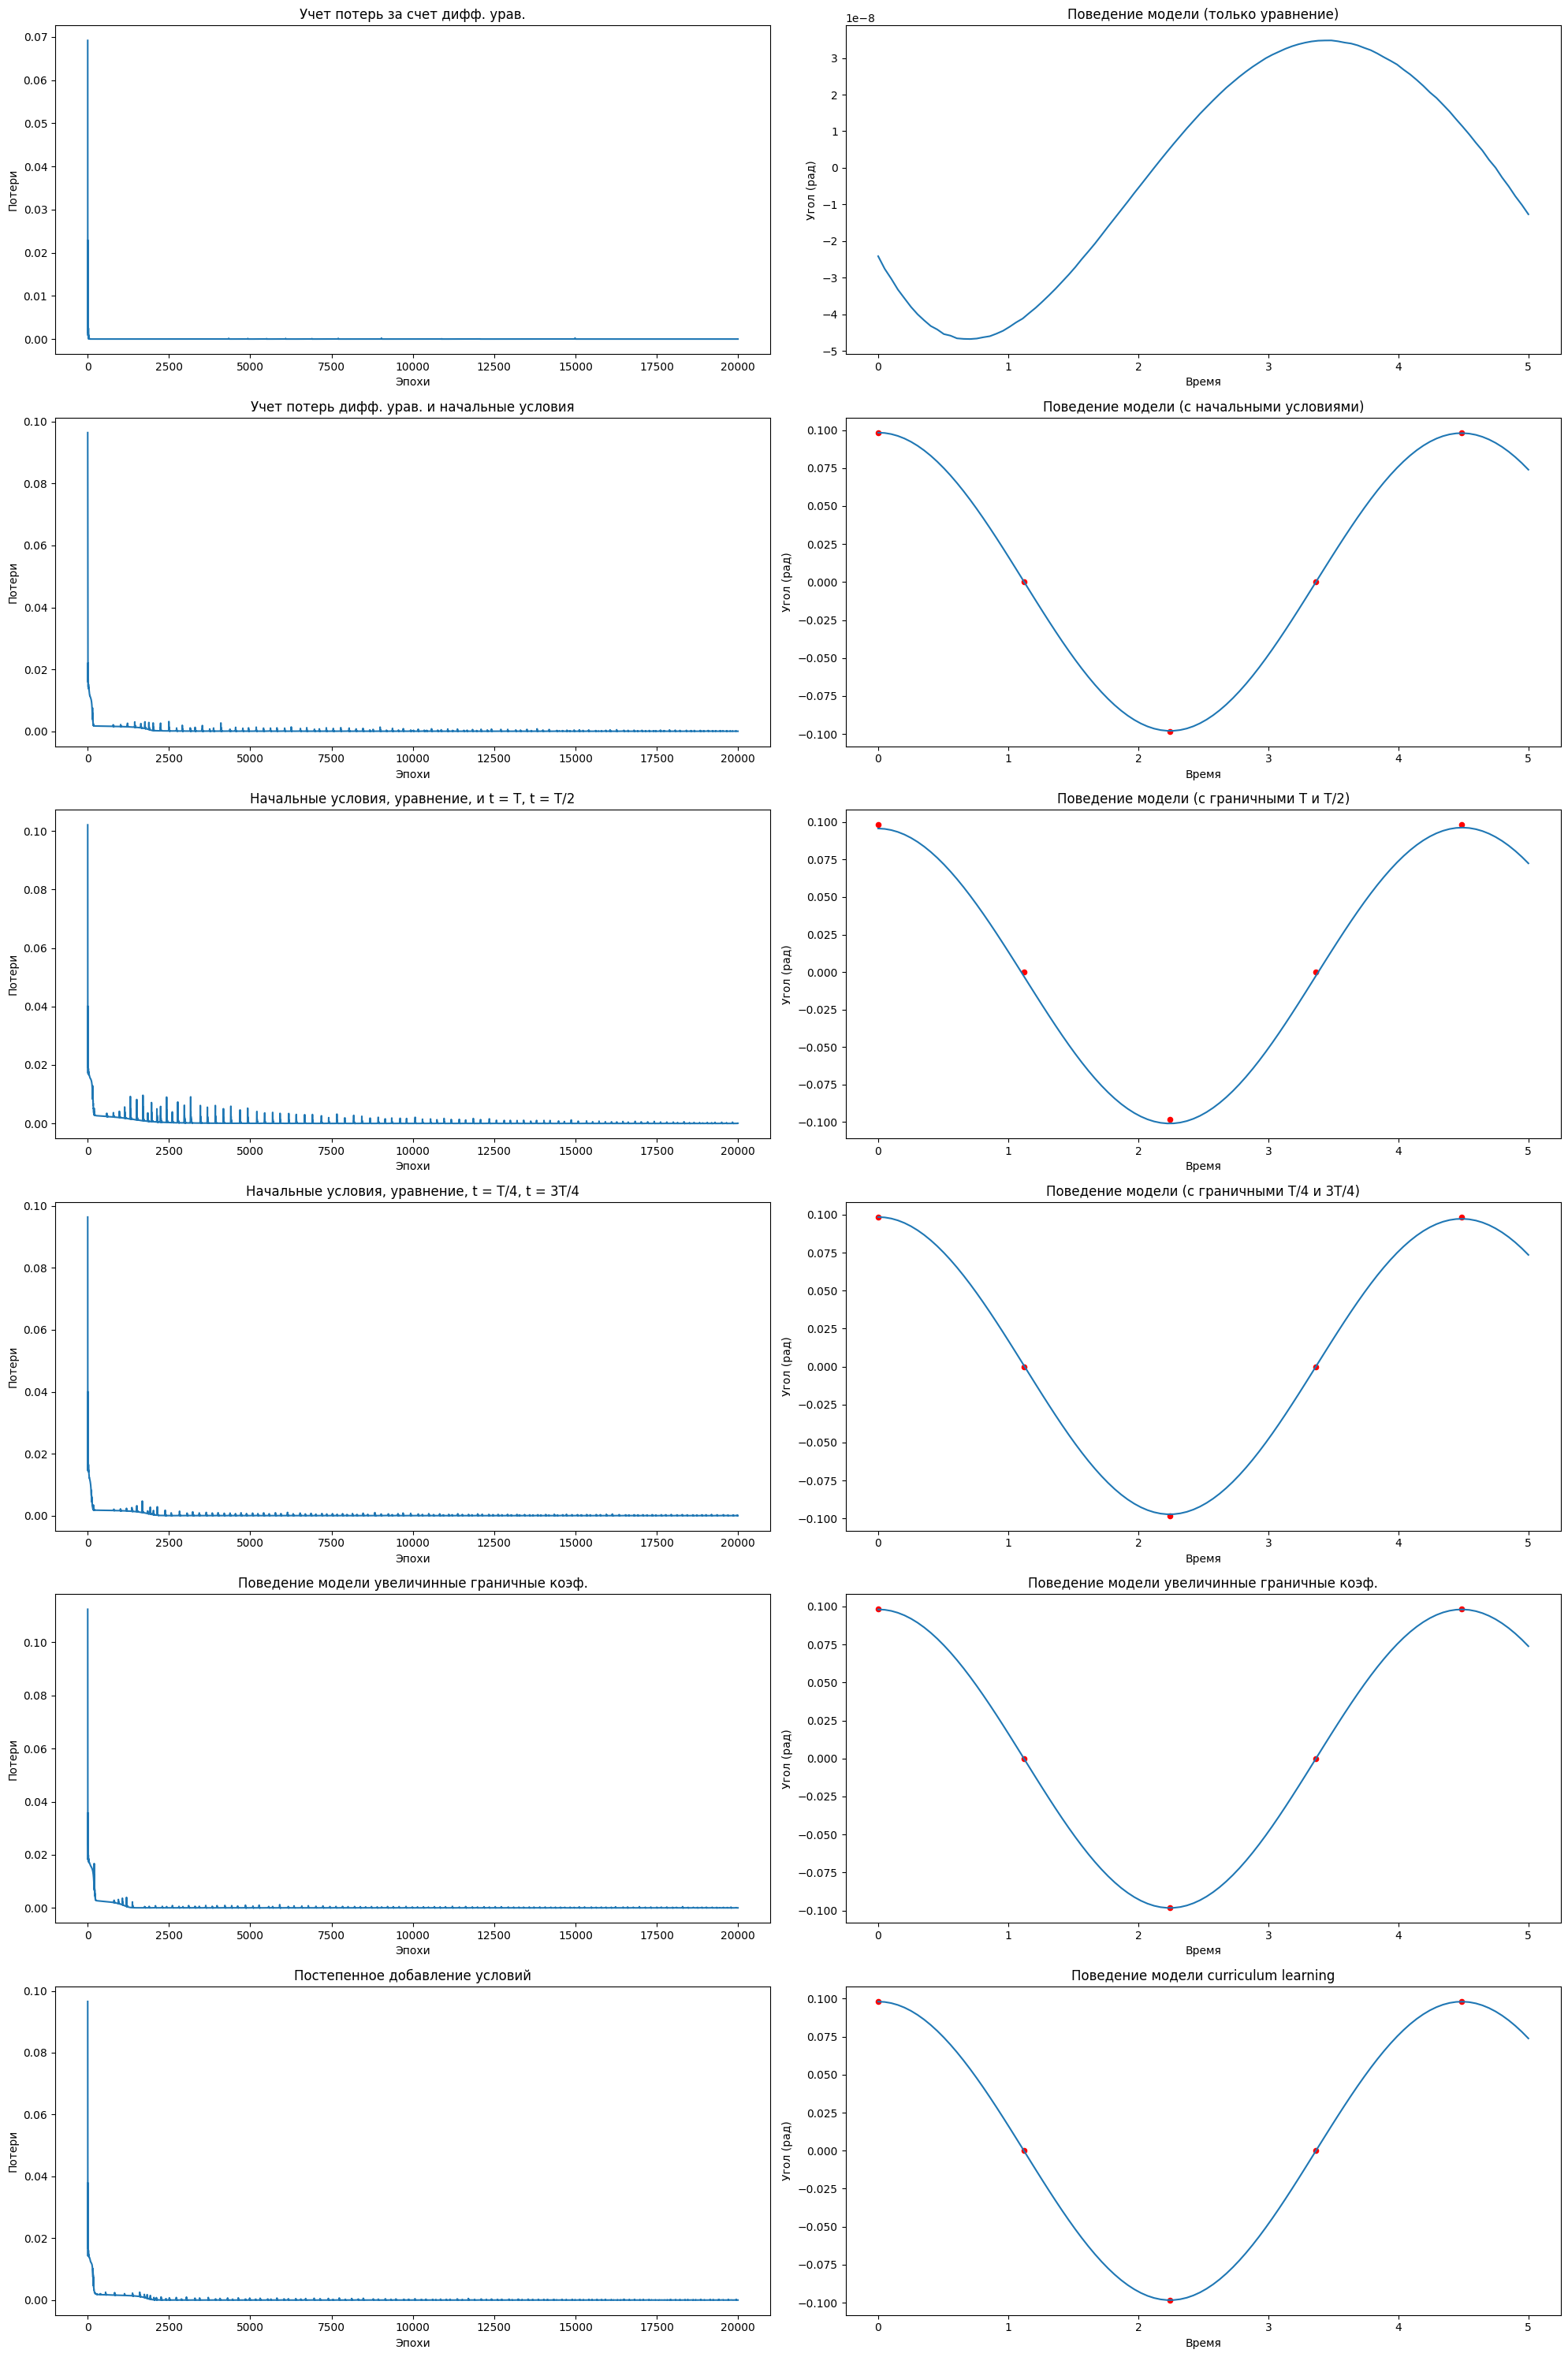

In [21]:
import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(6, 2, figsize=(20, 30))

# Общие настройки
epoch_for_graph = np.linspace(0, epoch, epoch+1)

T_approx = 2 * torch.pi * torch.sqrt(torch.tensor(L/g))

t_graph = np.array ([0.0, T_approx/4, T_approx/2, 3*T_approx/4, T_approx])
angle_graph = np.array ([theta_max, 0.0, -theta_max, 0.0, theta_max])


# График 1 (строка 0)
axs[0,0].plot(epoch_for_graph, loss_equation)
axs[0,0].set_title("Учет потерь за счет дифф. урав.")
axs[0,0].set_xlabel('Эпохи')
axs[0,0].set_ylabel('Потери')

axs[0,1].plot(test_time.detach().numpy(), predict_model_equation.detach().numpy())
axs[0,1].set_title("Поведение модели (только уравнение)")
axs[0,1].set_xlabel('Время')
axs[0,1].set_ylabel('Угол (рад)')

# График 2 (строка 1)
axs[1,0].plot(epoch_for_graph, loss_initial)
axs[1,0].set_title("Учет потерь дифф. урав. и начальные условия")
axs[1,0].set_xlabel('Эпохи')
axs[1,0].set_ylabel('Потери')

axs[1,1].plot(test_time.detach().numpy(), predict_model_initial.detach().numpy())
axs[1,1].scatter (t_graph, angle_graph, s = 20, c = 'r', marker = 'o')
axs[1,1].set_title("Поведение модели (с начальными условиями)")
axs[1,1].set_xlabel('Время')
axs[1,1].set_ylabel('Угол (рад)')

# График 3 (строка 2)
axs[2,0].plot(epoch_for_graph, loss_initial_boundary_1)
axs[2,0].set_title("Начальные условия, уравнение, и t = T, t = T/2")
axs[2,0].set_xlabel('Эпохи')
axs[2,0].set_ylabel('Потери')

axs[2,1].plot(test_time.detach().numpy(), predict_model_boundary_1.detach().numpy())
axs[2,1].set_title("Поведение модели (с граничными T и T/2)")
axs[2,1].scatter (t_graph, angle_graph, s = 20, c = 'r', marker = 'o')
axs[2,1].set_xlabel('Время')
axs[2,1].set_ylabel('Угол (рад)')

# График 4 (строка 3)
axs[3,0].plot(epoch_for_graph, loss_initial_boundary_2)
axs[3,0].set_title("Начальные условия, уравнение, t = T/4, t = 3T/4")
axs[3,0].set_xlabel('Эпохи')
axs[3,0].set_ylabel('Потери')

axs[3,1].plot(test_time.detach().numpy(), predict_model_boundary_2.detach().numpy())
axs[3,1].scatter (t_graph, angle_graph, s = 20, c = 'r', marker = 'o')
axs[3,1].set_title("Поведение модели (с граничными T/4 и 3T/4)")
axs[3,1].set_xlabel('Время')
axs[3,1].set_ylabel('Угол (рад)')

# График 5 (строка 4)
axs[4,0].plot(epoch_for_graph, loss_initial_period)
axs[4,0].set_title("Поведение модели увеличинные граничные коэф.")
axs[4,0].set_xlabel('Эпохи')
axs[4,0].set_ylabel('Потери')

axs[4,1].plot(test_time.detach().numpy(), predict_model_period.detach().numpy())
axs[4,1].scatter (t_graph, angle_graph, s = 20, c = 'r', marker = 'o')
axs[4,1].set_title("Поведение модели увеличинные граничные коэф.")
axs[4,1].set_xlabel('Время')
axs[4,1].set_ylabel('Угол (рад)')

# График 5 (строка 4)
axs[5,0].plot(epoch_for_graph, loss_initial_dynamic)
axs[5,0].set_title("Постепенное добавление условий")
axs[5,0].set_xlabel('Эпохи')
axs[5,0].set_ylabel('Потери')

axs[5,1].plot(test_time.detach().numpy(), predict_model_period.detach().numpy())
axs[5,1].scatter (t_graph, angle_graph, s = 20, c = 'r', marker = 'o')
axs[5,1].set_title("Поведение модели curriculum learning")
axs[5,1].set_xlabel('Время')
axs[5,1].set_ylabel('Угол (рад)')

plt.tight_layout()
plt.show()